In [1]:
import sys
sys.path.append("../model/")
# sys.path.append("../../loss/")


In [2]:
pwd

'/mnt/nas100_vol2/LeeJungHoon/Segmentation/OCT_task/Experiments_LJH'

## test

In [3]:
import os
import cv2
import json
import math
import random
import imageio
import numpy as np
import nibabel as nib
import albumentations
import shutil
import re

from glob import glob
from tqdm import tqdm
from unet_official import UNet
from matplotlib import pyplot as plt
from dice_score import multiclass_dice_coeff, dice_loss

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

# from torchsummary import summary
from datetime import datetime

from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

from skimage.filters import median
from skimage.morphology import disk

In [4]:
def seed_all(seed=42):
    print("Using Seed Number {}".format(seed))

    os.environ["PYTHONHASHSEED"] = str(seed)  # set PYTHONHASHSEED env var at fixed value
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)  # pytorch (both CPU and CUDA)
    np.random.seed(seed)  # for numpy pseudo-random generator
    random.seed(seed)  # set fixed value for python built-in pseudo-random generator
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False

def seed_worker(_worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
seed_all()

Using Seed Number 42


In [5]:
def is_cache(filename):
    return filename == '.ipynb_checkpoints'

def del_cache(file_list):
    if '.ipynb_checkpoints' in file_list:
        file_list.remove('.ipynb_checkpoints')
    if '@eaDir' in file_list:
        file_list.remove('@eaDir')
    return file_list

## Load train image/mask 

In [6]:
pwd

'/mnt/nas100_vol2/LeeJungHoon/Segmentation/OCT_task/Experiments_LJH'

In [7]:
p = '../data/labeling'
p_list = del_cache(os.listdir(p))
print(p_list)

['0', '1', '2']


In [ ]:
patient_dict

In [ ]:
inputs

In [ ]:
dataset = list(zip(inputs, targets))
random.shuffle(dataset)
inputs, targets = zip(*dataset)

# 간단하게 확인
print(inputs[:2])
print(targets[:2])

## device 정의

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
device

device(type='cuda', index=0)

## Dataset & DataLoader

In [9]:
def get_patches(img, mask, overlap=0.0, patch_size=256):
    h, w = np.shape(img)
    
    img_patch_list = []
    mask_patch_list = []
    
    patch_num = math.ceil((w - h) / (h * (1 - overlap))) + 1
    
    for w_start_idx in np.linspace(0, w-h, patch_num):
        w_start_idx = int(w_start_idx)
        img_patch = img[:, w_start_idx:w_start_idx+h]
        mask_patch = mask[:, w_start_idx:w_start_idx+h]
        
        X_per = patch_size / h
        resized_img = cv2.resize(img_patch, dsize=(0, 0), fx=X_per, fy=X_per, interpolation=cv2.INTER_NEAREST)
        img_patch_list.append(resized_img)
        
        resized_mask = cv2.resize(mask_patch, dsize=(0, 0), fx=X_per, fy=X_per, interpolation=cv2.INTER_NEAREST)
        mask_patch_list.append(resized_mask)
        
    return img_patch_list, mask_patch_list

In [10]:
def remove_artifact(img, mask, filter_size=(1, 5), overlap=0.4, threshold = 25):
    MEAN_VALUE = 127.5
    removed_img = img.copy()
    
    mask_h, mask_w = mask.shape
    filter_h, filter_w = filter_size[0], filter_size[1]
    
    patch_num = math.ceil((mask_w - filter_w) / (filter_w * (1 - overlap))) + 1
    
    for h_start_idx in range(0, mask_h, filter_h):
        for w_start_idx in np.linspace(0, mask_w-filter_w, patch_num):
            w_start_idx = int(w_start_idx)
            mask_region = mask[h_start_idx:h_start_idx+filter_h, w_start_idx:w_start_idx+filter_w]
            mask_region_unique_value = np.unique(mask_region)
            
            if 0 in mask_region_unique_value or 10 in mask_region_unique_value:
                continue
            
            img_region = removed_img[h_start_idx:h_start_idx+filter_h, w_start_idx:w_start_idx+filter_w]
            
            for h in range(filter_h):
                pixel_list = img_region[h, :]
                mean_pixel = int(np.mean(pixel_list))
                
                less = [element for element in pixel_list if element < mean_pixel] + [mean_pixel]
                greater = [element for element in pixel_list if element > mean_pixel] + [mean_pixel]

                for idx, element in enumerate(pixel_list): 
                    # 대체적으로 밝다
                    if mean_pixel > MEAN_VALUE and element - mean_pixel <= -threshold:
                        pixel_list[idx] = random.choice(greater)
                    # 대체적으로 어둡다
                    elif mean_pixel < MEAN_VALUE and element - mean_pixel >= threshold:
                        pixel_list[idx] = random.choice(less)      
    return removed_img

In [11]:
def remove_artifact(img, mask, name, threshold=2):
    removed_img = img.copy()
    
    # 배경과 맥랙막을 제외한 망막 layer들
    for label_num in range(1, 10):
        mask_region = mask == label_num
        
        if len(mask_region) == 0:
            print(f'{label_num} >>> {name}')
        img_region = removed_img[mask_region]
        
        mean = np.mean(img_region)
        std = np.std(img_region)
        
        outlier = [] 
        normal = []
        
        for pixel in img_region:
            z_score = abs(pixel - mean) / std 

            if z_score > threshold: 
                outlier.append(pixel)
            else:
                normal.append(pixel)

        for idx, pixel in enumerate(img_region):
            if pixel in outlier:
                img_region[idx] = random.choice(normal)
                
        removed_img[mask_region] = img_region
        
    return removed_img

In [12]:
pwd

'/mnt/nas100_vol2/LeeJungHoon/Segmentation/OCT_task/Experiments_LJH'

In [12]:
train_image_path = '../data/train_data/V2/train/image/*.png' 
train_mask_path = '../data/train_data/V2/train/mask/*.png' 

valid_image_path = '../data/train_data/V2/valid/image/*.png' 
valid_mask_path = '../data/train_data/V2/valid/mask/*.png' 

test_image_path = '../data/train_data/V2/test/image/*.png' 
test_mask_path = '../data/train_data/V2/test/mask/*.png' 

In [ ]:
b = glob(train_image_path)
c = glob(train_mask_path)

for a, b in zip(b, c):
    print(a,b)
    img = cv2.imread(a, cv2.IMREAD_GRAYSCALE)
    ma = cv2.imread(b, cv2.IMREAD_GRAYSCALE)


In [16]:
len(b)

51

In [14]:
class OCT_Dataset(Dataset):
    def __init__(self, image_path, mask_path, transform_with_mask=None):
        self.image_path_list = sorted(glob(image_path))
        self.mask_path_list = sorted(glob(mask_path))
        
        self.image_list = []
        self.mask_list = []
        
        self.transform_with_mask = transform_with_mask
        
        
        for (image_path, mask_path) in zip(self.image_path_list, self.mask_path_list):
            
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            '''
            # RAA
            image = median(image, disk(1))
            mask = median(mask, disk(5))
            
            # RVA
            image = remove_artifact(image, mask, image_path, threshold=1.5)            
            '''
            
            # Aug
            # image = np.expand_dims(image, axis=0)
            
            if self.transform_with_mask:

                image = np.squeeze(image)

                augmented = self.transform_with_mask(image=image, mask=mask)
                augmented_image, augmented_mask = augmented['image'], augmented['mask']
            
                augmented_image = np.expand_dims(augmented_image, axis=0)
                # augmented_mask = np.expand_dims(augmented_mask, axis=0)
                
                # print(augmented_image.shape)
                # print(augmented_mask.shape)
                
                # 동환 선생님이 했던 것과 순서가 다름 원래와 같은 순서대로 들어갈 경우 같은 data가 두 번 들어가기 때문에 
                # append하는 부분을 마지막에 추가해주기
                # self.image_list.append(torch.from_numpy(augmented_image).float())
                # self.mask_list.append(torch.from_numpy(augmented_mask).float())
                            
                self.image_list.append(torch.from_numpy(augmented_image).float())
                self.mask_list.append(torch.from_numpy(augmented_mask).float())
            
            else:
                image = np.expand_dims(image, axis=0)
                # mask = np.expand_dims(mask, axis=0)
                
                self.image_list.append(torch.from_numpy(image).float())
                self.mask_list.append(torch.from_numpy(mask).float())
            
    def __len__(self):
        return len(self.image_list)
        
    def __getitem__(self, idx):
        return {'image': self.image_list[idx], 'mask': self.mask_list[idx], 'filename' : self.image_path_list[idx]}

In [15]:
batch_size = 8

# dataset_size = len(inputs)
# # Augmentation 이후 train:valid:test 비율이 
# # 6:2:2 => 3/7, 2/7
# # 8:1:1 => 2/3, 1/6

# train_size = round(dataset_size * 0.8)
# validation_size = round(dataset_size * 0.1)
# test_size = dataset_size - train_size - validation_size
# print(dataset_size)
# print(f'{train_size}:{validation_size}:{test_size}')

train_transform_with_mask = albumentations.Compose([
    albumentations.ShiftScaleRotate(shift_limit=0, scale_limit=(0,0.2), rotate_limit=0, p=0.3, interpolation=1, border_mode=cv2.BORDER_REPLICATE),
    # albumentations.RandomCropFromBorders(crop_left=0, crop_right=0, crop_top=0.05, crop_bottom=0.05, always_apply=False, p=0.3),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.CLAHE(clip_limit=(1,2), p=0.3),
    albumentations.Resize(512,512, interpolation = cv2.INTER_AREA)    
    ])

transform_with_mask = albumentations.Resize(512,512, interpolation = cv2.INTER_AREA)

train_dataset = OCT_Dataset(train_image_path, train_mask_path, transform_with_mask)
validation_dataset = OCT_Dataset(valid_image_path, valid_mask_path, transform_with_mask)
test_dataset = OCT_Dataset(test_image_path, test_mask_path, transform_with_mask)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, worker_init_fn=seed_worker)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=1)

print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(validation_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

Training Data Size : 663
Validation Data Size : 78
Testing Data Size : 104


In [16]:
# print(validation_dataset[0]['mask'].shape)
train_dataset[0]['filename'].split('/')[-1]

'10554838_OD_05.png'

In [ ]:
for idx, batch in enumerate(validation_dataloader):
    if idx == 10:
        break
    images = batch['image']
    targets = batch['mask']
    print(images.type)
    print(images.shape)
    print(targets.shape)
    
    fig = plt.figure(figsize=(16, 16))

    plt.subplot(1, 2, 1)
    plt.imshow(images[0].squeeze(), cmap='gray')

    plt.subplot(1, 2, 2)
    plt.imshow(targets[0].squeeze(), cmap='gray')

    plt.tight_layout()
    plt.show()

## Train & Validation

In [18]:
net = UNet(1, 11).to(device)
# summary(net, (1, 512, 512))

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# scheduler = ReduceLROnPlateau(optimizer, 'min')

def train_one_epoch(training_loader, epoch, tb_writer):
    running_loss = 0.0
    total_dice_score = 0.0
    num_train_batches = len(training_loader)
    dice_score_per_layer = {}
    
    for idx, batch in enumerate(training_loader):
        '''
        images = []
        targets = []
        
        for image, mask in zip(batch['image'], batch['mask']):
            augmented = transform(image=image.numpy(), mask=mask.numpy())
            image, mask = augmented['image'], augmented['mask']

            image = np.expand_dims(image, axis=0)

            images.append(image)
            targets.append(mask)

        images = torch.from_numpy(np.array(images)).to(device=device, dtype=torch.float32)
        targets = torch.from_numpy(np.array(targets)).to(device=device, dtype=torch.long)
        '''
        
        images = batch['image'].to(device=device, dtype=torch.float32)
        targets = batch['mask'].to(device=device, dtype=torch.long)
        
        optimizer.zero_grad()

        masks_pred = net(images)
        
        
        loss = criterion(masks_pred, targets)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        # running_loss_arr += [loss.item()]
        # batch_mean_loss = np.mean(running_loss_arr)
        
        targets = F.one_hot(targets, net.n_classes).permute(0, 3, 1, 2).float()
        masks_pred = F.one_hot(masks_pred.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()
    
        dice_score, dice_score_list = multiclass_dice_coeff(masks_pred[:, 1:, ...], targets[:, 1:, ...], reduce_batch_first=False)
        total_dice_score += dice_score
        
        batch_dice_score_per_layer = {idx + 1: dice_score.item() for idx, dice_score in enumerate(dice_score_list)}
        
        for layer, dice_score in batch_dice_score_per_layer.items():
            if dice_score_per_layer.get(layer) == None:
                dice_score_per_layer[layer] = dice_score
            else:
                dice_score_per_layer[layer] += dice_score
    else:
        last_loss = running_loss / num_train_batches
        avg_vscore = total_dice_score / num_train_batches
        train_dice_score_per_layer = {layer: round(dice_score / num_train_batches, 3) for layer, dice_score in dice_score_per_layer.items()}
        
        print(f'| epoch {epoch} |\ntrain loss: {last_loss:.3f} \ntrain dice_score: {avg_vscore:.3f} \ntrain_dice_score_per_layer: {json.dumps(train_dice_score_per_layer, sort_keys = False, indent = 4)}')
        tb_writer.add_scalar('Loss/train', last_loss, epoch)
        tb_writer.add_scalar('Dice_Score/train', avg_vscore, epoch)
    return last_loss, avg_vscore

## tensorboard

In [20]:
from torch.utils.tensorboard import SummaryWriter
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
os.mkdir(f'/mnt/nas100_vol2/LeeJungHoon/Segmentation/OCT_task/checkpoints/train(JHL_newsplit_curation)')
# writer = SummaryWriter(f'../runs/{timestamp}')
writer = SummaryWriter('/mnt/nas100_vol2/LeeJungHoon/Segmentation/OCT_task/runs/train(JHL_newsplit_curation)')

In [ ]:
epochs = 50
best_vloss = 1_000_000.0
best_vscore = 0.0
num_val_batches = len(validation_dataloader)

loss_history = {'train': [], 'val': []}
metric_history = {'train': [], 'val': []}

for epoch in tqdm(range(1, epochs+1)):
    net.train()
    avg_loss, avg_vscore = train_one_epoch(train_dataloader, epoch, writer)
    loss_history['train'].append(avg_loss)
    metric_history['train'].append(avg_vscore)

    
    net.eval()
    running_vloss = 0.0
    total_dice_score = 0.0
    dice_score_per_layer = {}
    
    with torch.no_grad():
        for idx, batch in enumerate(validation_dataloader):
            images = batch['image']
            targets = batch['mask']

#             images = images.unsqueeze(1)
        
            images = images.to(device=device, dtype=torch.float32)
            targets = targets.to(device=device, dtype=torch.long)

            masks_pred = net(images)
            # print(masks_pred.shape)
            loss = criterion(masks_pred, targets)
            
            running_vloss += loss
            
            targets = F.one_hot(targets, net.n_classes).permute(0, 3, 1, 2).float()
            masks_pred = F.one_hot(masks_pred.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()

            dice_score, dice_score_list = multiclass_dice_coeff(masks_pred[:, 1:, ...], targets[:, 1:, ...], reduce_batch_first=False)
            total_dice_score += dice_score
            
            for idx, dice_score in enumerate(dice_score_list):
                if dice_score_per_layer.get(idx + 1) == None:
                    dice_score_per_layer[idx + 1] = dice_score.item()
                else:
                    dice_score_per_layer[idx + 1] += dice_score.item()
    
    avg_vloss = running_vloss / num_val_batches
    avg_val_vscore = total_dice_score / num_val_batches
    valid_dice_score_per_layer = {layer: round(dice_score / num_val_batches, 3) for layer, dice_score in dice_score_per_layer.items()}
    
#     scheduler.step(avg_vloss)
    print(f'valid loss: {avg_vloss:.3f} \nvalid dice_score: {avg_val_vscore:.3f} \nvalid_dice_score_per_layer: {json.dumps(valid_dice_score_per_layer, sort_keys=False, indent=4)}')
    
    writer.add_scalar('Loss/valid', avg_vloss, epoch)
    writer.add_scalar('Dice_Score/valid', avg_vscore, epoch)
    
    loss_history['val'].append(avg_vloss)
    metric_history['val'].append(avg_val_vscore)
        
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        
        path = f'/mnt/nas100_vol2/LeeJungHoon/Segmentation/OCT_task/checkpoints/train(JHL_newsplit_curation)/best_loss_{epoch}.pth'
        torch.save(net.state_dict(), path)

    if avg_vscore > best_vscore:
        best_vscore = avg_vscore
        
        path = f'/mnt/nas100_vol2/LeeJungHoon/Segmentation/OCT_task/checkpoints/train(JHL_newsplit_curation)/best_score_{epoch}.pth'
        torch.save(net.state_dict(), path)

# 결과 시각화

Text(0.5, 1.0, 'Dice loss')

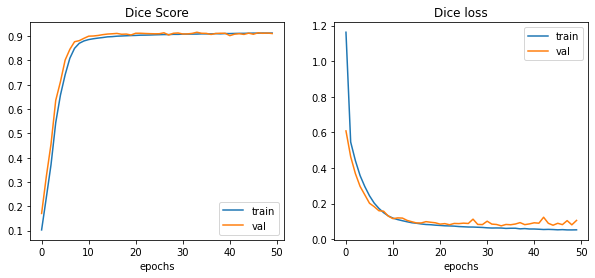

In [22]:
accuracy = metric_history['train']
val_accuracy = metric_history['val'] 

loss = loss_history['train'] 
val_loss = loss_history['val']

epochs = range(len(loss_history['train']))

fig = plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label="train") 
plt.plot(epochs, val_accuracy, label="val")
plt.xlabel('epochs')
plt.legend() 
plt.title('Dice Score') 

plt.subplot(1, 2, 2)
# plt.figure()
plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="val") 
plt.xlabel('epochs')
plt.legend() 
plt.title('Dice loss')

## Test

In [24]:
# 시각화를 위한 RGB값

mask_rgb = {
    0: [0, 0, 0],
    1: [255, 0, 0],
    2: [0, 255, 0],
    3: [0, 0, 255],
    4: [255, 255, 0],
    5: [0, 255, 255],
    6: [255, 0, 255],
    7: [208, 200, 187],
    8: [93, 93, 195],
    9: [207, 171, 136],
    10: [221, 206, 186],
    11: [51, 204, 204]
}

In [25]:
def gray_to_rgb(gray_image):
    rgb_img = np.zeros((512, 512, 3))
    
    for layer, rgb_value in mask_rgb.items():
        class_region = gray_image == layer
        rgb_img[class_region.cpu()] = rgb_value
        
    return rgb_img

In [ ]:
filename = "best_loss_34.pth"
checkpoint_path = f"/mnt/nas100_vol2/LeeJungHoon/Segmentation/OCT_task/checkpoints/train(JHL_newsplit_curation)/{filename}" 
net.load_state_dict(torch.load(checkpoint_path))
net.eval()

In [27]:
# 결과 이미지 저장 폴더 생성
os.mkdir(f'/mnt/nas100_vol2/LeeJungHoon/Segmentation/OCT_task/test_results/train(JHL_newsplit_curation)')
save_path = '/mnt/nas100_vol2/LeeJungHoon/Segmentation/OCT_task/test_results/train(JHL_newsplit_curation)'

In [ ]:
fn_tonumpy = lambda x : x.to('cpu').detach().numpy().transpose(1,2,0)
# net.eval()
test_loss = 0.0
test_dice_score = 0.0
dice_score_per_layer = {}
num_test_batches = len(test_dataloader)

with torch.no_grad():
    
    for idx, batch in enumerate(test_dataloader):
        
        images = batch['image']
        targets = batch['mask']
        
        name = batch['filename']
    
        last_name = name[0].split('/')[-1]
        patient = last_name.split('_')[0]
        lateral = last_name.split('_')[1]
        img_num_png = last_name.split('_')[2]
        img_num = re.split('[.]+', img_num_png)[0]

        images = images.to(device=device, dtype=torch.float32)
        targets = targets.to(device=device, dtype=torch.long)

        masks_pred = net(images)

        loss = criterion(masks_pred, targets)

        test_loss += loss
        
        masks_pred = masks_pred.argmax(dim=1)
        
        # for image, target, pred_array in zip(images, targets, masks_pred):
        # print(targets.squeeze().shape)
        target_img = gray_to_rgb(targets.squeeze())
        pred_img = gray_to_rgb(masks_pred.squeeze())

        #결과 이미지 저장
        imgs = np.hstack((target_img, pred_img))
        # print(imgs.shape)
        plt.imshow(imgs.astype('uint8'))
        # print(f'{save_path}/{patient}_{lateral}_{img_num}')
        print(patient)
        print(img_num)
        # plt.imsave(os.path.join(save_path, '%s_%s_%s.png' % (patient, lateral, img_num)), imgs.astype('uint8'))

        # destination = f'{save_path}'
        # save = shutil.copy2(imgs, f"{destination}/{patient}_{lateral}_{img_num}")

        fig = plt.figure(figsize=(20, 20)) 

        print(images.squeeze(0).shape)
        print(target_img.shape)
        
        plt.subplot(1, 3, 1)
        plt.imshow(fn_tonumpy(images.cpu().squeeze(0)), cmap = plt.cm.gray)

        plt.subplot(1, 3, 2)
        plt.imshow(target_img.astype('uint8'))

        plt.subplot(1, 3, 3)
        plt.imshow(pred_img.astype('uint8'))

        plt.tight_layout()
        plt.show()

        targets = F.one_hot(targets, net.n_classes).permute(0, 3, 1, 2).float()
        masks_pred = F.one_hot(masks_pred, net.n_classes).permute(0, 3, 1, 2).float()

        dice_score, dice_score_list = multiclass_dice_coeff(masks_pred[:, 1:, ...], targets[:, 1:, ...], reduce_batch_first=False)
        test_dice_score += dice_score

        for idx, dice_score in enumerate(dice_score_list):
            if dice_score_per_layer.get(idx + 1) == None:
                dice_score_per_layer[idx + 1] = dice_score.item()
            else:
                dice_score_per_layer[idx + 1] += dice_score.item()
                
avg_test_loss = test_loss / num_test_batches
avg_test_score = test_dice_score / num_test_batches
test_dice_score_per_layer = {layer: round(dice_score / num_test_batches, 3) for layer, dice_score in dice_score_per_layer.items()}

print(f'test loss: {avg_test_loss:.3f} \ntest dice_score: {avg_test_score:.3f} \ntest_dice_score_per_layer: {json.dumps(test_dice_score_per_layer, sort_keys=False, indent=4)}')

writer.add_scalar('Loss/test', avg_test_loss, epoch)
writer.add_scalar('Dice_Score/test', avg_test_score, epoch)

writer.flush()

In [37]:
imgs.shape

(512, 1024, 3)